In [31]:
#Importar librerias 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Para mostrar el arbol de decision
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

import numpy as np

In [2]:
# Cargar el dataset
star_data = pd.read_csv('estrellas.csv')
# star_data.head()

# Verificar si hay valores nulos
# print(star_data.isnull().sum())

# No hay valores nulos

In [3]:
X = star_data.drop(columns='Spectral Class')
y = star_data['Spectral Class']

# Dividir en train, test y validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [4]:
def preprocesar_variables_categoricas(data):
    '''Preprocesar variables categoricas'''
    # Obtener dummies de columnas Star type, Star category, Star color
    dummies = pd.get_dummies(data[['Star type', 'Star category', 'Star color']])
    # Eliminar columnas originales
    data.drop(columns=['Star type', 'Star category', 'Star color'], inplace=True)
    # Concatenar dummies
    data = pd.concat([data, dummies], axis=1)
    return data

X_train = preprocesar_variables_categoricas(X_train)
X_val = preprocesar_variables_categoricas(X_val)
X_test = preprocesar_variables_categoricas(X_test)

In [5]:
# Get all columns in X_train, X_val and X_test
all_columns = set(X_train.columns).union(set(X_val.columns)).union(set(X_test.columns))

# Add missing columns to X_train, X_val and X_test
for column in all_columns:
    if column not in X_train.columns:
        X_train[column] = False
    if column not in X_val.columns:
        X_val[column] = False
    if column not in X_test.columns:
        X_test[column] = False

# Reorder columns
X_train = X_train[list(all_columns)]
X_val = X_val[list(all_columns)]
X_test = X_test[list(all_columns)]

features = list(X_train.columns)


In [6]:
# Normalizar datos
def normalizar_datos(data):
    '''Normalizar datos'''
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return data

X_train = normalizar_datos(X_train)
X_val = normalizar_datos(X_val)
X_test = normalizar_datos(X_test)

In [15]:
# # Evaluar accuracy, precision, recall y F1
def obtener_metricas_evaluacion(y_real, y_predicho):
    '''Obtener metricas de evaluacion'''

    matrix_confusion = confusion_matrix(y_real, y_predicho)
    print('Accuracy:', get_accuracy(matrix_confusion))
    print('Precision:', get_precision(matrix_confusion))
    print('Recall:', get_recall(matrix_confusion))
    print('F1:', get_f1(matrix_confusion))
    
    sns.heatmap(matrix_confusion, annot=True, fmt='d')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()

def get_accuracy(matrix_confusion):
    '''Obtener accuracy'''
    sum = 0
    for i in range(len(matrix_confusion)):
        sum += matrix_confusion[i][i]
    return sum / matrix_confusion.sum()

def get_precision(matrix_confusion):
    '''Obtener precision'''
    columns = []
    for i in range(len(matrix_confusion)):
        if matrix_confusion[i,:].sum() == 0:
            columns.append(0)
        else:
            columns.append(matrix_confusion[i][i] / matrix_confusion[i, :].sum())
    return columns

def get_recall(matrix_confusion):
    '''Obtener recall'''
    rows = []
    for i in range(len(matrix_confusion)):
        if matrix_confusion[:,i].sum() == 0:
            rows.append(0)
        else:
            rows.append(matrix_confusion[i][i] / matrix_confusion[:, i].sum())
    return rows

def get_f1(matrix_confusion):
    '''Obtener F1'''
    precision = get_precision(matrix_confusion)
    recall = get_recall(matrix_confusion)
    f1 = []
    for i in range(len(precision)):
        if precision[i] + recall[i] == 0:
            f1.append(0)
        else:
            f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
    return f1


In [61]:
# Crear un dataframe para almacenar los resultados
resultados = pd.DataFrame(columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1', 'Description'])

def agregar_resultados(modelo_nombre, y_real, y_predicho, descripcion=''):
    '''Agregar resultados al dataframe'''
    matrix_confusion = confusion_matrix(y_real, y_predicho)
    accuracy = get_accuracy(matrix_confusion)
    precision = np.mean(get_precision(matrix_confusion))
    recall = np.mean(get_recall(matrix_confusion))
    f1 = np.mean(get_f1(matrix_confusion))
    
    resultados.loc[len(resultados)] = [modelo_nombre, accuracy, precision, recall, f1, descripcion]


In [62]:
modelo_random_forest = RandomForestClassifier()
modelo_random_forest.fit(X_train, y_train)
y_pred = modelo_random_forest.predict(X_val)

agregar_resultados('Random Forest', y_val, y_pred, 'n_estimators=100, max_depth=None')

modelo_random_forest = RandomForestClassifier(n_estimators=200)
modelo_random_forest.fit(X_train, y_train)
y_pred = modelo_random_forest.predict(X_val)

agregar_resultados('Random Forest', y_val, y_pred, 'n_estimators=200, max_depth=None')

modelo_random_forest = RandomForestClassifier(n_estimators=200, max_depth=10)
modelo_random_forest.fit(X_train, y_train)
y_pred = modelo_random_forest.predict(X_val)

agregar_resultados('Random Forest', y_val, y_pred, 'n_estimators=100, max_depth=10')


In [63]:
# Entrenar modelo Regresion Logistica
modelo_regresion_logistica = LogisticRegression()
modelo_regresion_logistica.fit(X_train, y_train)
y_pred = modelo_regresion_logistica.predict(X_val)

agregar_resultados('Regresion Logistica', y_val, y_pred, 'max_iter=100, C=1')

# Entrenar modelo Regresion Logistica
modelo_regresion_logistica = LogisticRegression(max_iter=200)
modelo_regresion_logistica.fit(X_train, y_train)
y_pred = modelo_regresion_logistica.predict(X_val)

agregar_resultados('Regresion Logistica', y_val, y_pred, 'max_iter=200, C=1')

# Entrenar modelo Regresion Logistica
modelo_regresion_logistica = LogisticRegression(max_iter=200, C=0.1)
modelo_regresion_logistica.fit(X_train, y_train)
y_pred = modelo_regresion_logistica.predict(X_val)

agregar_resultados('Regresion Logistica', y_val, y_pred, 'max_iter=200, C=0.1')


In [67]:
modelo_svm = SVC()
modelo_svm.fit(X_train, y_train)
y_pred = modelo_svm.predict(X_val)

agregar_resultados('SVM', y_val, y_pred, 'C=1, kernel=rbf')

modelo_svm = SVC(C=0.1)
modelo_svm.fit(X_train, y_train)
y_pred = modelo_svm.predict(X_val)

agregar_resultados('SVM', y_val, y_pred, 'C=0.1, kernel=rbf')

modelo_svm = SVC(C=0.1, kernel='linear')
modelo_svm.fit(X_train, y_train)
y_pred = modelo_svm.predict(X_val)

agregar_resultados('SVM', y_val, y_pred, 'C=0.1, kernel=linear')




In [65]:
modelo_decision_tree = DecisionTreeClassifier()
modelo_decision_tree.fit(X_train, y_train)
y_pred = modelo_decision_tree.predict(X_val)

agregar_resultados('Decision Tree', y_val, y_pred, 'max_depth=None, min_samples_split=2')

modelo_decision_tree = DecisionTreeClassifier(max_depth=10)
modelo_decision_tree.fit(X_train, y_train)
y_pred = modelo_decision_tree.predict(X_val)

agregar_resultados('Decision Tree', y_val, y_pred, 'max_depth=10, min_samples_split=2')

modelo_decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
modelo_decision_tree.fit(X_train, y_train)
y_pred = modelo_decision_tree.predict(X_val)

agregar_resultados('Decision Tree', y_val, y_pred, 'max_depth=10, min_samples_split=5')

Métricas en el conjunto de validación:
Accuracy: 0.8974358974358975
Precision: [1.0, 0.6666666666666666, 0.75, 0.0, 1.0, 1.0]
Recall: [0.8, 1.0, 0.75, 0, 0.9411764705882353, 0.8888888888888888]
F1: [0.888888888888889, 0.8, 0.75, 0, 0.9696969696969697, 0.9411764705882353]


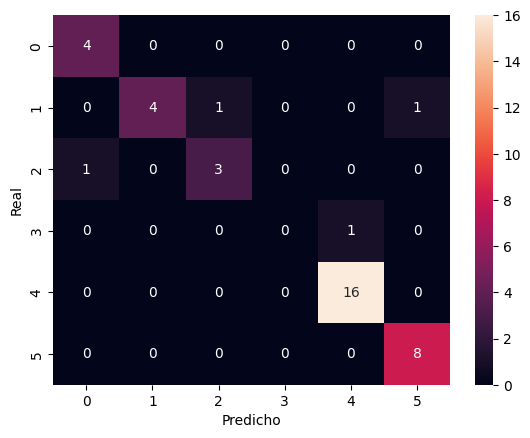

0.8974358974358975
0.8812803753980223
0.8974358974358975
0.8820543291131526
Métricas en el conjunto de testeo:
Accuracy: 0.875
Precision: [1.0, 1.0, 1.0, 0.0, 1.0, 0.7]
Recall: [1.0, 0.7142857142857143, 0.5, 0, 1.0, 1.0]
F1: [1.0, 0.8333333333333333, 0.6666666666666666, 0, 1.0, 0.8235294117647058]


c:\Users\agust\AppData\Local\miniconda3\envs\gurobienv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


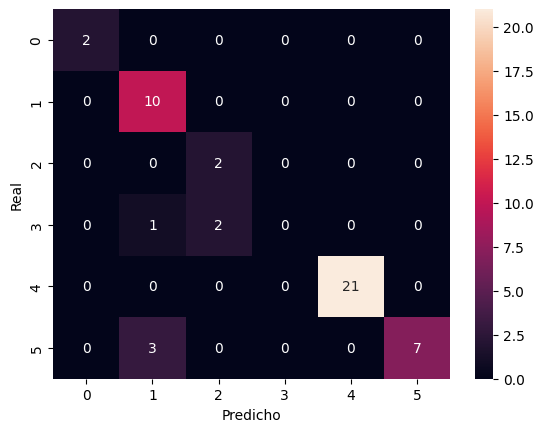

0.875
0.8571428571428571
0.875
0.852124183006536


c:\Users\agust\AppData\Local\miniconda3\envs\gurobienv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [81]:
# Seleccionar el mejor modelo basado en la métrica de Accuracy
modelo = RandomForestClassifier(n_estimators=200, max_depth=10)

modelo.fit(X_train, y_train)

# Probar el modelo en el conjunto de validación
y_pred = modelo.predict(X_val)

# Probar el modelo en el conjunto de testeo
y_pred_test = modelo.predict(X_test)

# Obtener métricas de evaluación para el conjunto de validación
print("Métricas en el conjunto de validación:")
obtener_metricas_evaluacion(y_val, y_pred)
print(accuracy_score(y_val, y_pred))
print(precision_score(y_val, y_pred, average='weighted'))
print(recall_score(y_val, y_pred, average='weighted'))
print(f1_score(y_val, y_pred, average='weighted'))



# Obtener métricas de evaluación para el conjunto de testeo
print("Métricas en el conjunto de testeo:")
obtener_metricas_evaluacion(y_test, y_pred_test)
print(accuracy_score(y_test, y_pred_test))
print(precision_score(y_test, y_pred_test, average='weighted'))
print(recall_score(y_test, y_pred_test, average='weighted'))
print(f1_score(y_test, y_pred_test, average='weighted'))



